In [23]:
#necessary libraries and imports
import QuantLib as ql 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from datetime import datetime
import torch
import torch.nn as nn
import time
from scipy.optimize import minimize
import torch.optim as optim
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset

In [2]:
#import the relevant data set
yields = pd.read_csv('https://people.bath.ac.uk/mapamgc/AT/data/daily-treasury-rates-ql.csv', index_col='Date') # Data from treasury.gov
yields

,1m,2m,3m,4m,6m,1y,2y,3y,5y,7y,10y,20y,30y
Date,,,,,,,,,,,,,
02/13/2025,4.37,4.39,4.34,4.35,4.33,4.27,4.31,4.31,4.39,4.46,4.52,4.79,4.72
02/12/2025,4.38,4.39,4.35,4.36,4.33,4.30,4.36,4.37,4.48,4.56,4.62,4.90,4.83
02/11/2025,4.38,4.40,4.35,4.37,4.31,4.25,4.29,4.28,4.37,4.45,4.54,4.80,4.75
02/10/2025,4.38,4.40,4.35,4.37,4.31,4.24,4.28,4.30,4.34,4.42,4.51,4.76,4.71
02/07/2025,4.37,4.38,4.35,4.37,4.30,4.25,4.29,4.31,4.34,4.42,4.49,4.75,4.69
02/06/2025,4.37,4.38,4.34,4.36,4.28,4.19,4.21,4.23,4.28,4.36,4.45,4.70,4.65
02/05/2025,4.35,4.37,4.33,4.35,4.27,4.17,4.17,4.19,4.24,4.33,4.43,4.69,4.64
02/04/2025,4.36,4.38,4.33,4.35,4.27,4.18,4.21,4.25,4.31,4.42,4.52,4.81,4.75
02/03/2025,4.37,4.38,4.34,4.35,4.28,4.20,4.26,4.28,4.35,4.45,4.54,4.82,4.77


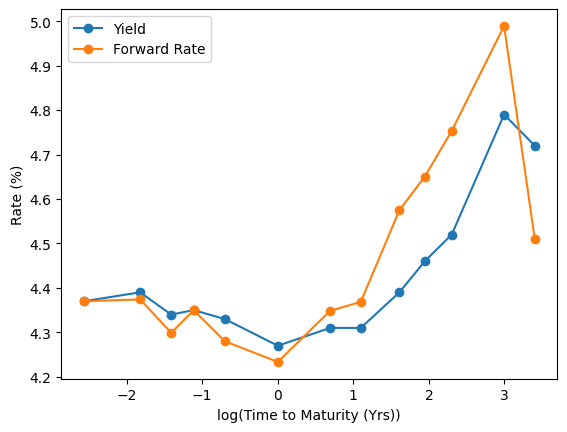

In [ ]:
#code to load the yield and forward rates, done by generating a zerocurve.

yields.index = pd.to_datetime(yields.index)
dayCounter = ql.ActualActual(ql.ActualActual.ISDA)
today = ql.Date(yields.index[0].day,yields.index[0].month,yields.index[0].year)
yield_list = list(yields)
maturities = [today + ql.Period(dl) for dl in yield_list]
z_curve = ql.ZeroCurve(maturities,yields.iloc[0,:].to_numpy()/100, dayCounter)

yld_dat = []
fwd_dat = []
tme_dat = []
price_dat = []


for d in z_curve.dates():
    yrs = dayCounter.yearFraction(today,d)
    tme_dat.append(yrs)
    z_rate = z_curve.zeroRate(d,dayCounter,ql.Continuous, ql.Annual)
    f_rate = z_curve.forwardRate(d,d,dayCounter,ql.Continuous, ql.Annual)
    yld_dat.append(z_rate.equivalentRate(dayCounter,ql.Continuous, ql.Annual,today,d).rate()*100)
    fwd_dat.append(f_rate.equivalentRate(dayCounter,ql.Continuous, ql.Annual,today,d).rate()*100)
    price_dat.append(z_curve.zeroRate(d,dayCounter,ql.Continuous, ql.Annual).discountFactor(yrs))

plt.plot(np.log(tme_dat),yld_dat,'o-',np.log(tme_dat),fwd_dat,'o-');

plt.legend(["Yield","Forward Rate"]);
plt.xlabel("log(Time to Maturity (Yrs))")
plt.ylabel("Rate (%)");

1.
**(i)**

In [4]:
#startiung parameter guess for Vasicek model: [r0, a, b, sigma]
a0 = [0.043, 0.1, 0.042, 0.002]

#function for predictions according to vasicek model on price data
def y_hat(a):
    r0, a_, b, sigma = a
    prices_hat = []
    try:
        vas = ql.Vasicek(r0, a_, b, sigma)
        for t in tme_dat:
            #getting model predictions at each maturity
            prices_hat.append(vas.discount(t))
         #returning residuals   
        return np.array(prices_hat) - np.array(price_dat)
    #incase function throws runtime error because of invalid parameters
    except RuntimeError as e:
        print(f"RuntimeError during Vasicek construction: {e}")
        # Return a large error to discourage these parameters
        return np.full_like(price_dat, 1e6)
        
#using LM Algorithm to fit vasicek parameters
res = least_squares(y_hat, a0, method='lm')

# Get best-fit parameters
r0_fit, a_fit, b_fit, sigma_fit = res.x
print(res.x)

RuntimeError during Vasicek construction: -5.42453: invalid value
RuntimeError during Vasicek construction: -0.457784: invalid value
[4.13088482e-02 8.80204151e-04 1.30096432e+00 8.44915072e-03]


In [5]:
#principal = M
M = 1.0

#fitting vasicek curve according to best parameters we got
vas_fit = ql.Vasicek(r0_fit,a_fit,b_fit,sigma_fit)

price_vas = []
for t in tme_dat:
        price_vas.append(vas_fit.discount(t))
    
#calculating yields from vasicek price data construction
yld_vas = [(M / P)**(1 / T) - 1 for P, T in zip(price_vas, tme_dat)]



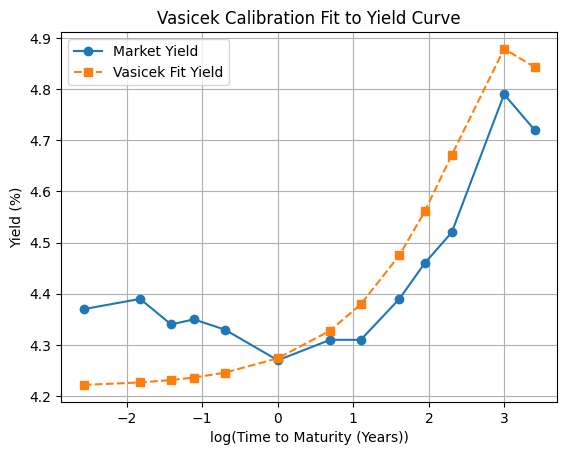

In [6]:
# Plotting vasicek curve and orignal market data
plt.plot(np.log(tme_dat), yld_dat, 'o-', label="Market Yield")
plt.plot(np.log(tme_dat), [y * 100 for y in yld_vas], 's--', label="Vasicek Fit Yield")
plt.xlabel("log(Time to Maturity (Years))")
plt.ylabel("Yield (%)")
plt.legend()
plt.title("Vasicek Calibration Fit to Yield Curve")
plt.grid(True)
plt.show()


**(ii)**

In [13]:
a0_hw = [0.043, 0.1, 0.002,0.3,0.1] #r0,a,sigma,c0,c1 according to hull-white model

#defining A,B,P functions according to hull white equation
def A_hw(tau, a, sigma, c0, c1):
    B = B_hw(tau, a)

    int_theta_B = (c0 / a) * (tau - B) + \
                    (c1 / a) * (0.5 * tau**2 - (tau / a) + (1 / a**2) * (1 - np.exp(-a * tau)))

    volatility_term = (sigma**2 / (2 * a**2)) * (tau - B - 0.5 * a * B**2)

    return np.exp(int_theta_B + volatility_term)


def B_hw(tau,a):
    return (1-np.exp(-a*tau))/a

def P_hw(tau, r0, a, sigma, c0, c1):
    A = A_hw(tau, a, sigma, c0, c1)
    B = B_hw(tau, a)
    return A * np.exp(-B * r0)

#function for predictions according to hull-white model on price data
def hw_y_hat(a):
    r0, a_, sigma, c0, c1 = a
    try:
        #getting model predictions at each maturity
        prices_hat = [P_hw(t, r0, a_, sigma, c0, c1) for t in tme_dat]
        return np.array(prices_hat) - np.array(price_dat)
    #incase function throws runtime error because of invalid parameters
    except Exception as e:
        print(f"Error during Hull-White pricing: {e}")
        return np.full_like(price_dat, 1e6)

#using LM Algorithm to fit vasicek parameters
hw_res = least_squares(hw_y_hat, a0_hw, method='lm')

# Extract fitted parameters
r0_fit, a_fit, sigma_fit, c0_fit, c1_fit = hw_res.x
print("Fitted parameters (corrected A):", hw_res.x)

# Get fitted prices and yields
price_hw = [P_hw(t, r0_fit, a_fit, sigma_fit, c0_fit, c1_fit) for t in tme_dat]
M = 1.0  # face value
#calculating yields from price data
yld_hw = [(M / P)**(1 / T) - 1 for P, T in zip(price_hw, tme_dat)]

yld_hw



/var/folders/1g/wp6hwywd54jf8ly8hnq696yr0000gn/T/ipykernel_8480/2951046950.py:12: RuntimeWarning: overflow encountered in exp
  return np.exp(int_theta_B + volatility_term)
/var/folders/1g/wp6hwywd54jf8ly8hnq696yr0000gn/T/ipykernel_8480/2951046950.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  return A * np.exp(-B * r0)


Fitted parameters (corrected A): [ 4.25531854e-02 -2.79000238e-01 -1.98707881e-05  1.13305870e-02
  1.51252418e-04]


[0.04349323567666241,
 0.043517242536615264,
 0.0435404752576527,
 0.043564482683208894,
 0.043611723914950495,
 0.04375422823645625,
 0.04403693702817124,
 0.044319577126987086,
 0.04488514039237268,
 0.045450398008909376,
 0.04629767714542754,
 0.04906441675767881,
 0.04833166627435026]

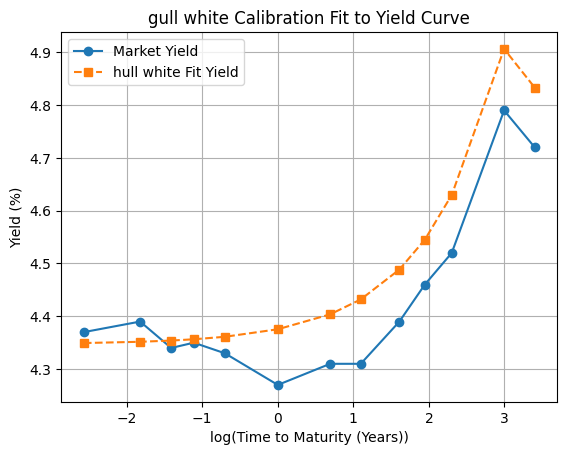

In [14]:
# Plotting hull white and market data
plt.plot(np.log(tme_dat), yld_dat, 'o-', label="Market Yield")
plt.plot(np.log(tme_dat), [y * 100 for y in yld_hw], 's--', label="hull white Fit Yield")
plt.xlabel("log(Time to Maturity (Years))")
plt.ylabel("Yield (%)")
plt.legend()
plt.title("gull white Calibration Fit to Yield Curve")
plt.grid(True)
plt.show()

2
**(i)**

In [15]:
# Function definitions for vasicek model
def B_vas(tau, a, b, sig):
    return (1 - np.exp(-a * tau)) / a

def A_vas(tau, a, b, sig):
    B_tau = B_vas(tau, a, b, sig)
    return np.exp((b - sig**2 / (2 * a**2)) * (B_tau - tau) - sig**2 * B_tau**2 / (4 * a))

def P_vas(tau, r0, a, b, sig):
    A_tau = A_vas(tau, a, b, sig)
    B_tau = B_vas(tau, a, b, sig)
    return A_tau * np.exp(-B_tau * r0)

# Function to generate yield curve using the vasicek model
def gen_vasicek_curve(params, maturities_years):
    r0, a, b, sigma = params
    spot_rates = []

    for T in maturities_years:
        P = P_vas(T, r0, a, b, sigma)
        # Calculate zero rate (yield) from the bond price
        if P <= 0:
            raise RuntimeError(f"Invalid bond price at maturity {T}")
        
        zero_rate = -np.log(P) / T
        spot_rates.append(zero_rate)
    return np.array(spot_rates)


In [16]:
# Generate synthetic data using the vasicek model
def gen_data(n_samples=1000, n_maturities=30):
    
    # Define maturities (in years)
    maturities = np.linspace(0.25, 30, n_maturities)
    
    # Randomly sample parameters for the vasicek model
    r0 = np.random.uniform(0.005, 0.07, n_samples)  # Initial short rate: 0.5% to 7%
    a = np.random.uniform(0.05, 0.5, n_samples)     # Mean reversion speed: 0.05 to 0.5
    b = np.random.uniform(0.01, 0.08, n_samples)    # Long-term mean: 1% to 8%
    sigma = np.random.uniform(0.005, 0.03, n_samples)  # Volatility: 0.5% to 3%
    # Stack the parameters together
    params = np.column_stack([r0, a, b, sigma])  
    # Generate the yield curves
    X = np.zeros((n_samples, n_maturities))
    for i in range(n_samples):
        X[i] = gen_vasicek_curve(params[i], maturities)
    
    return X, params, maturities


Starting traning
Epoch [10/50], Train Loss: 0.004275, Val Loss: 0.004927
Epoch [20/50], Train Loss: 0.004067, Val Loss: 0.004549
Epoch [30/50], Train Loss: 0.004066, Val Loss: 0.004479
Epoch [40/50], Train Loss: 0.004002, Val Loss: 0.004439
Epoch [50/50], Train Loss: 0.003998, Val Loss: 0.004417
Evaluating model performance
Mean Squared Error between original and reconstructed yield curves: 0.0001


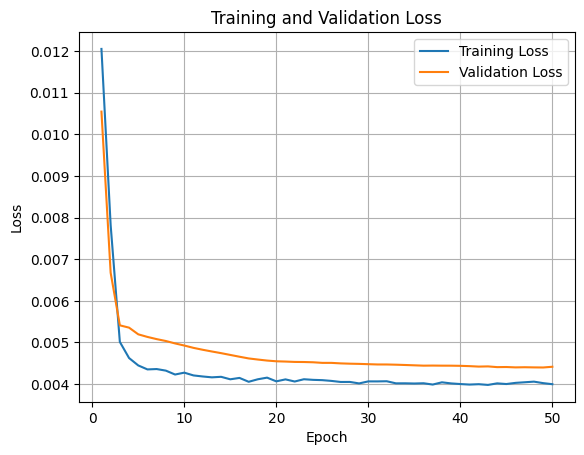

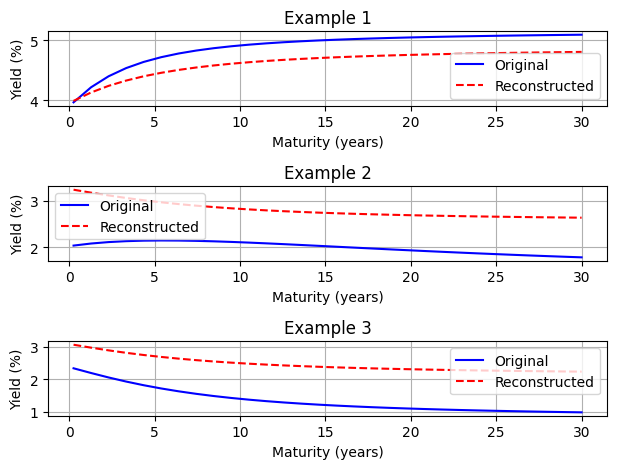

In [20]:
#neural network model to predict vasicek parameters from yield curves
class YieldCurveNN(nn.Module):
    
    def __init__(self, input_dim, hid_dim=64, output_dim=4):
        
        super(YieldCurveNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hid_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hid_dim, output_dim)
        )      
    def forward(self, x):
        outputs = self.network(x)
        #constraints to ensure parameters are within a valid range
        r0 = torch.sigmoid(outputs[:, 0]) * 0.15       # 0% to 15%
        a = torch.sigmoid(outputs[:, 1]) * 1.0         # 0 to 1.0
        b = torch.sigmoid(outputs[:, 2]) * 0.15        # 0% to 15%
        sigma = torch.sigmoid(outputs[:, 3]) * 0.05    # 0% to 5%
        return torch.stack([r0, a, b, sigma], dim=1)

# generate the data
n_samples = 1000
n_maturities = 30
X, y, maturities = gen_data(n_samples, n_maturities)

# Split into training and validation sets
train_size = int(0.8 * n_samples)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the neural network and adam optimizer
model = YieldCurveNN(input_dim=n_maturities)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
print("Starting traning")
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

# Function to evaluate models performance
def eval_model(model, X, y, maturities):
    model.eval()
    with torch.no_grad():
        # get predicted parameters
        y_pred = model(torch.FloatTensor(X)).numpy()
    
    # generate  yield curves from the predicted parameters
    X_recon = np.zeros_like(X)
    for i in range(len(y_pred)):
        X_recon[i] = gen_vasicek_curve(y_pred[i], maturities)
    
    # Calculate MSE between original and reconstructed yield curves
    mse = np.mean((X - X_recon) ** 2)
    print(f"Mean Squared Error between original and reconstructed yield curves: {mse:.4f}")
    
    return y_pred, X_recon

# Evaluate the model's performance on the validation set
test_indices = [0, 5, 10]
print("Evaluating model performance")
y_pred, X_recon = eval_model(model, X_val[test_indices], y_val[test_indices], maturities)

# Visualization of loss curves
def plot_loss_curves(train_losses, val_losses):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plottingg the loss curves
plot_loss_curves(train_losses, val_losses)

# Visualization of original and reconstructed yield curves
def plot_yield_curves(X_original, X_reconstructed, maturities, indices):
    for i, idx in enumerate(indices):
        plt.subplot(len(indices), 1, i + 1)
        plt.plot(maturities, X_original[idx] * 100, 'b-', label='Original')
        plt.plot(maturities, X_reconstructed[idx] * 100, 'r--', label='Reconstructed')
        plt.xlabel('Maturity (years)')
        plt.ylabel('Yield (%)')
        plt.title(f'Example {i+1}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot original vs reconstructed yield curves
plot_yield_curves(X_val[test_indices], X_recon, maturities, range(len(test_indices)))


**2.ii.**

Generating model data...
Trainng neural network
Epoch 0: Validation Loss = 0.004532
Epoch 10: Validation Loss = 0.004078
Epoch 20: Validation Loss = 0.003952
Epoch 30: Validation Loss = 0.003720
Epoch 40: Validation Loss = 0.002581

Running benchmarks
Curve 1: Direct fit MSE=0.000000, time=0.158s
Curve 1: NN fit MSE=0.000786, time=0.005s
Curve 2: Direct fit MSE=0.000000, time=0.142s
Curve 2: NN fit MSE=0.006820, time=0.003s
Curve 3: Direct fit MSE=0.000000, time=0.143s
Curve 3: NN fit MSE=0.007608, time=0.002s

Plottting results.


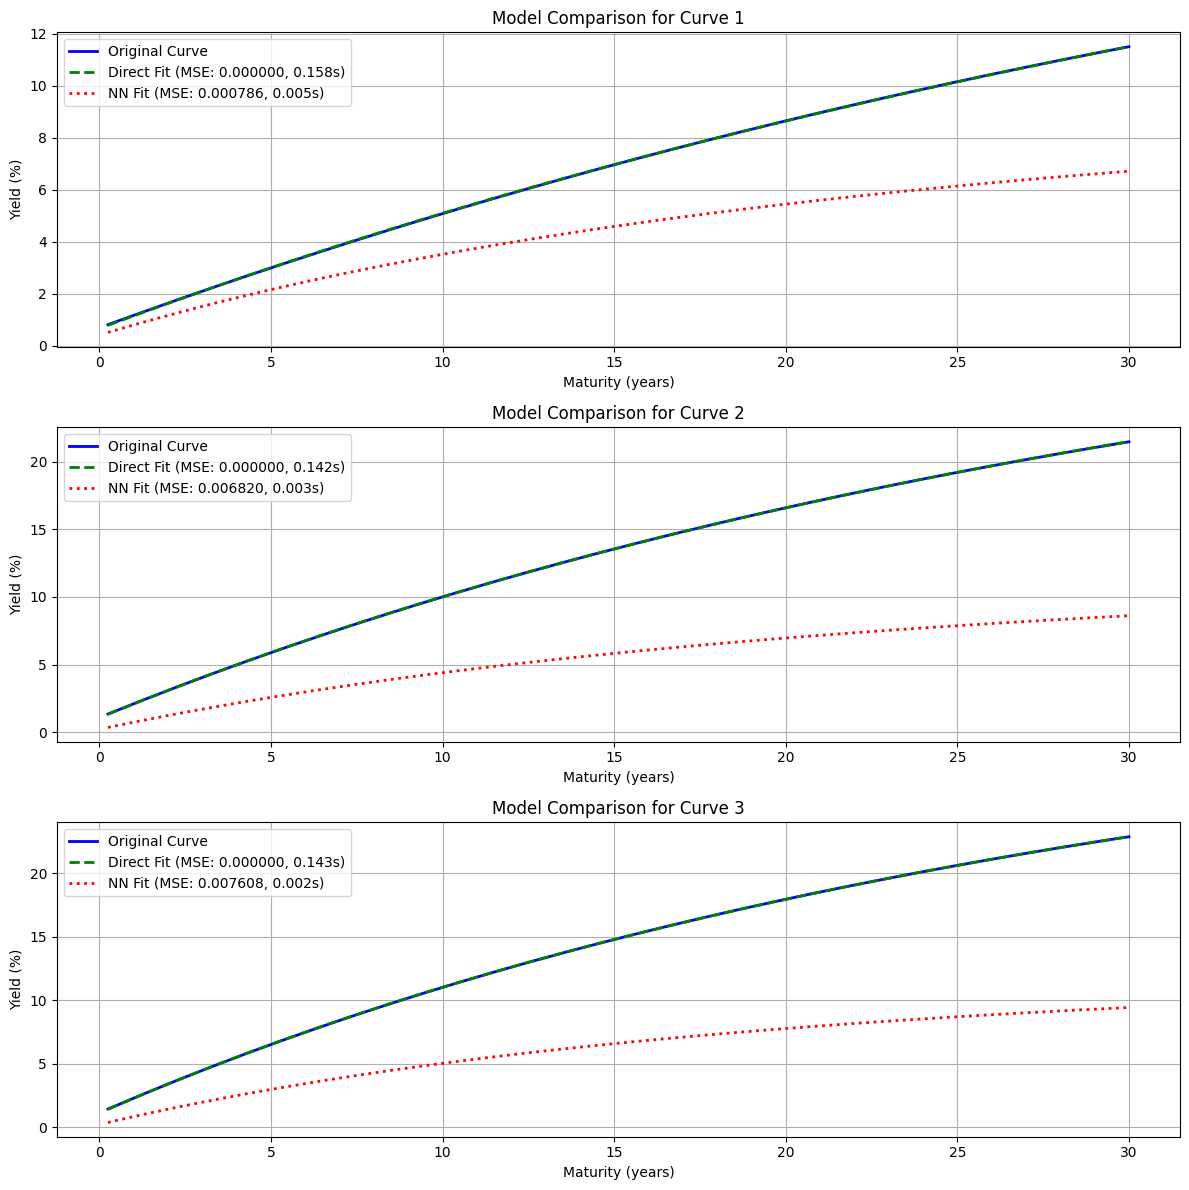

In [25]:
# function to generate CIR curve using quantlib
def gen_cir_curve(params, maturities):
    r0, a, b, sigma = params
    today = ql.Date().todaysDate()
    ql.Settings.instance().evaluationDate = today
    
    cir = ql.CoxIngersollRoss(r0, a, b, sigma)
    
    spot_rates = []
    for T in maturities:
        maturity_date = today + ql.Period(int(T * 365), ql.Days)
        time_to_maturity = ql.Actual365Fixed().yearFraction(today, maturity_date)
        discount = cir.discountBond(0.0, time_to_maturity, r0)
        zero_rate = -np.log(discount) / time_to_maturity
        spot_rates.append(zero_rate)
    
    return np.array(spot_rates)


# Generate synthetic model data
def generate_model_data(n_samples=100, n_maturities=30, model_type="cir"):
    maturities = np.linspace(0.25, 30, n_maturities)
    
    # settinf random parameters
    r0 = np.random.uniform(0.005, 0.07, n_samples)
    a = np.random.uniform(0.05, 0.5, n_samples)
    b = np.random.uniform(0.01, 0.08, n_samples)
    sigma = np.random.uniform(0.005, 0.03, n_samples)
    
    # Ensure Feller condition for CIR model
    if model_type == "cir":
        for i in range(n_samples):
            while 2*a[i]*b[i] <= sigma[i]**2:
                a[i] = max(a[i], 0.1)
                b[i] = max(sigma[i]**2/(2*a[i]) + 0.01, b[i])
    
    params = np.column_stack([r0, a, b, sigma])
    
    # Generate yield curves
    X = np.zeros((n_samples, n_maturities))
    for i in range(n_samples):
        if model_type == "cir":
            X[i] = gen_cir_curve(params[i], maturities)
        else:
            X[i] = gen_vasicek_curve(params[i], maturities)
    
    return X, params, maturities

# Direct parameter fitting by optimization
def fit_model_to_curve(yield_curve, maturities, model_type="cir"):
    def objective(params):
        r0, a, b, sigma = params
        r0 = max(0.001, r0)
        a = max(0.01, a)
        b = max(0.001, b)
        sigma = max(0.001, sigma)
        
        if model_type == "cir" and 2*a*b <= sigma**2:
            b = max(sigma**2/(2*a) + 0.01, b)
        
        try:
            if model_type == "cir":
                model_curve = gen_cir_curve([r0, a, b, sigma], maturities)
            else:
                model_curve = gen_vasicek_curve([r0, a, b, sigma], maturities)
            return np.mean((yield_curve - model_curve)**2)
        except:
            return 1e10
    
    initial_guess = [0.03, 0.1, 0.05, 0.01]
    bounds = [(0.001, 0.15), (0.01, 1.0), (0.001, 0.15), (0.001, 0.05)]
    
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    return result.x

# Simple neural network
class YieldCurveNN(nn.Module):
    def __init__(self, input_dim, output_dim=4):
        super(YieldCurveNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, x):
        outputs = self.network(x)
        r0 = torch.sigmoid(outputs[:, 0]) * 0.15
        a = torch.sigmoid(outputs[:, 1]) * 1.0
        b = torch.sigmoid(outputs[:, 2]) * 0.15
        sigma = torch.sigmoid(outputs[:, 3]) * 0.05
        return torch.stack([r0, a, b, sigma], dim=1)

# Run benchmarks comparing direct fitting vs neural network
def run_benchmark(X_test, maturities, model, n_samples=3, model_type="cir"):
    results = []
    
    for i in range(n_samples):
        curve_data = {'original': X_test[i]}
        
        # Time direct fit
        start_time = time.time()
        try:
            direct_params = fit_model_to_curve(X_test[i], maturities, model_type)
            if model_type == "cir":
                direct_curve = gen_cir_curve(direct_params, maturities)
            else:
                direct_curve = gen_vasicek_curve(direct_params, maturities)
            direct_mse = np.mean((X_test[i] - direct_curve)**2)
            direct_time = time.time() - start_time
            curve_data['direct'] = {
                'curve': direct_curve,
                'mse': direct_mse,
                'time': direct_time
            }
            print(f"Curve {i+1}: Direct fit MSE={direct_mse:.6f}, time={direct_time:.3f}s")
        except Exception as e:
            print(f"Error with direct fit: {str(e)}")
        
        # Time neural network prediction
        start_time = time.time()
        with torch.no_grad():
            nn_params = model(torch.FloatTensor(X_test[i]).unsqueeze(0)).numpy()[0]
        
        try:
            nn_curve = gen_vasicek_curve(nn_params, maturities)
            nn_mse = np.mean((X_test[i] - nn_curve)**2)
            nn_time = time.time() - start_time
            curve_data['nn'] = {
                'curve': nn_curve,
                'mse': nn_mse,
                'time': nn_time
            }
            print(f"Curve {i+1}: NN fit MSE={nn_mse:.6f}, time={nn_time:.3f}s")
        except Exception as e:
            print(f"Error with NN fit: {str(e)}")
        
        results.append(curve_data)
    
    return results

# Plot results with one curve red and one curve green
def plot_comparison(results, maturities):
    plt.figure(figsize=(12, 4 * len(results)))
   
    for i, curve_data in enumerate(results):
        plt.subplot(len(results), 1, i+1)
       
        # Original curve in blue
        plt.plot(maturities, curve_data['original'] * 100, 'b-', linewidth=2, label='Original Curve')
       
        # Direct fit in green
        if 'direct' in curve_data:
            plt.plot(maturities, curve_data['direct']['curve'] * 100, 'g--', linewidth=2,
                     label=f"Direct Fit (MSE: {curve_data['direct']['mse']:.6f}, {curve_data['direct']['time']:.3f}s)")
       
        # Neural network fit in red
        if 'nn' in curve_data:
            plt.plot(maturities, curve_data['nn']['curve'] * 100, 'r:', linewidth=2,
                     label=f"NN Fit (MSE: {curve_data['nn']['mse']:.6f}, {curve_data['nn']['time']:.3f}s)")
       
        plt.xlabel('Maturity (years)')
        plt.ylabel('Yield (%)')
        plt.title(f'Model Comparison for Curve {i+1}')
        plt.legend()
        plt.grid(True)
   
    plt.tight_layout()
    plt.show()


# Setup parameters
n_samples = 5000 
n_maturities = 30
train_ratio = 0.8

# Generate data
print("Generating model data...")
X_cir, y_cir, maturities = generate_model_data(n_samples, n_maturities, "cir")
X_vas, y_vas, _ = generate_model_data(n_samples, n_maturities, "vasicek")

# Split data
n_train = int(train_ratio * n_samples)
X_train, y_train = X_vas[:n_train], y_vas[:n_train]
X_val, y_val = X_vas[n_train:], y_vas[n_train:]

# Creaye and train the model
print("Trainng neural network")
input_dim = X_train.shape[1]
model = YieldCurveNN(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor).item()
            print(f"Epoch {epoch}: Validation Loss = {val_loss:.6f}")

# Run benchmarks
print("\nRunning benchmarks")
benchmark_results = run_benchmark(X_cir, maturities, model, n_samples=3)

# Plot results
print("\nPlottting results.")
plot_comparison(benchmark_results, maturities)